In [7]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
workingDirectory = '/home/h1bennet/liverStrains/results/181009_kupffer_ly6c_tba/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Order of samples for plotting

In [9]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### QC

In [10]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [11]:
qc_rna = ngs_qc('./tag_directories_rna/', 'rna')

C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMDM_RNA_GW3965_1uM_C573A_CMB_l20180625_CACCGG does not contain a mapping log file
C57B6J_BMD

/home/h1bennet/anaconda3/envs/tba/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

### Create count files

In [12]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./expression/ ]; then mkdir ./expression; fi

# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
# # analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

In [13]:
# read in rpkm
rpkm = pd.read_csv('./expression/rna_exp_rpkm.tsv', sep='\t')
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)
# set rpkm index
mm10_gene = rpkm['Annotation/Divergence'].str.split('|').str[0]

# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
# change index to gene names
rpkm['gene'] = mm10_gene
rpkm = rpkm.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes with length < 250 bp
rpkm = rpkm.loc[rpkm.Length >= 250, :]

# drop pooled sample
rpkm = rpkm.drop(columns=['C57B6J_BloodLy6cHi_RNA_NoTx_Pooled_MS_l20171111_CGATGT']) # ,
#                           'C57Bl6_BloodLy6cHi_RNA_20wkControlDiet_JSSTDT_Rep1_JSS_s20180814_CGATGT',
#                           'C57Bl6_BloodLy6cHi_RNA_20wkControlDiet_JSSTDT_Rep2_JSS_s20180814_TGACCA'])

# filter genes expressed under 4 rpkm in all samples 
rpkm_filt = rpkm.loc[(rpkm.iloc[:, 7:] > 4).all(1), :]

In [14]:
# make group labels
cell = rpkm.iloc[:, 7:].columns.to_series().str.split('_').str[1]
diet = rpkm.iloc[:, 7:].columns.to_series().str.split('_').str[3]

### Make figures for PCA

In [15]:
# make folder to store expression figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')
if not os.path.isdir('./figures/expression_figures'):
    os.mkdir('./figures/expression_figures')

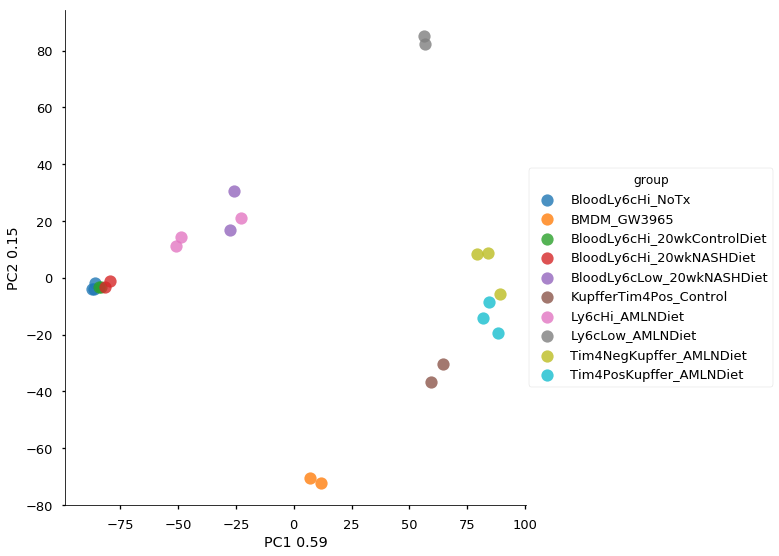

In [16]:
pca, exp_var, weights = pca_rpkm_mat(rpkm.iloc[:, 7:],
             group_labels=cell+'_'+diet,
             n_pca=10)
plt.savefig('./figures/expression_figures/rna_pca_with_bmdm.pdf', bbox_inches='tight')

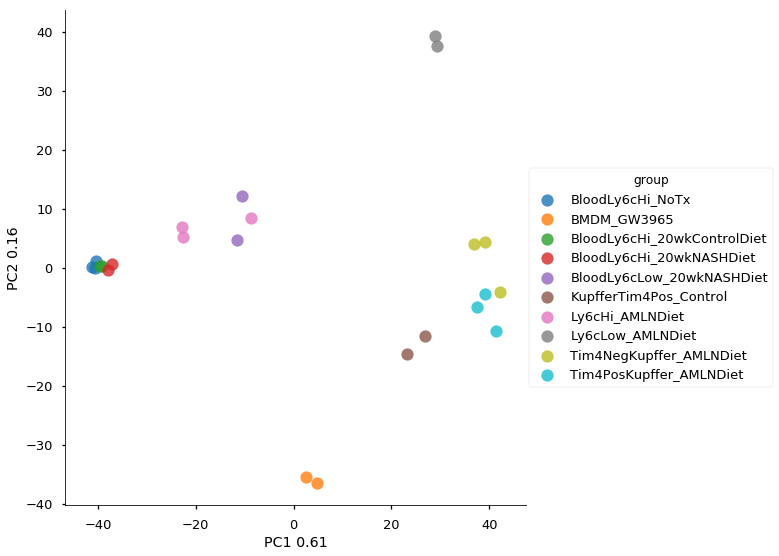

In [17]:
pca, exp_var, weights = pca_rpkm_mat(rpkm_filt.iloc[:, 7:],
             group_labels=cell+'_'+diet,
             n_pca=10)
plt.savefig('./figures/expression_figures/rna_pca_filtered_with_bmdm.pdf', bbox_inches='tight')

Quantile normalized PCA

In [18]:
rpkm_quant = quantile_normalize_df(rpkm.iloc[:, 7:])
rpkm_quant_filt = quantile_normalize_df(rpkm_filt.iloc[:, 7:])

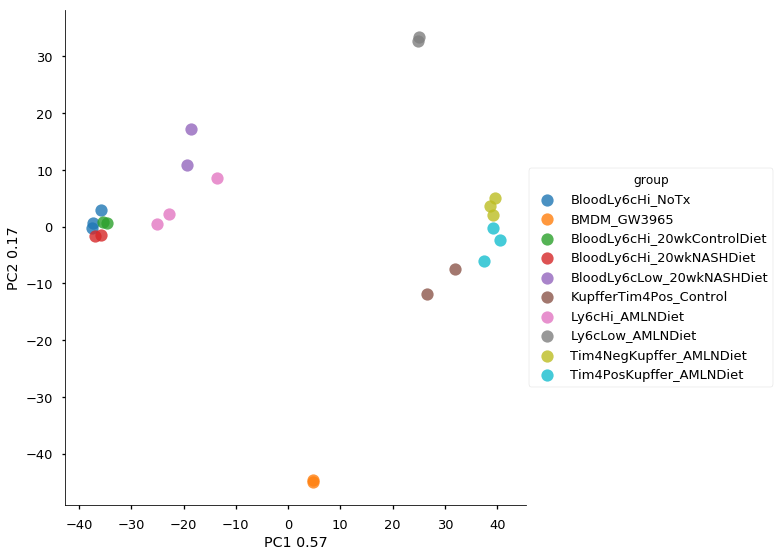

In [19]:
pca, exp_var, weights = pca_rpkm_mat(rpkm_quant_filt,
             group_labels=cell+'_'+diet,
             n_pca=10)
plt.savefig('./figures/expression_figures/rna_pca_filtered_quantile_normalized_with_bmdm.pdf', bbox_inches='tight')

Interestingly it looks like Ly6cLow hepatic monocytes are the most similar on PC1 to kupffer cells

### Look at weights vs expression

In [20]:
# import motif weights
motif_meta = pd.read_csv('/home/h1bennet//code/abtba/motif_metadata.tsv',
                         sep='\t',
                         index_col=0)
# drop duplicated index
motif_meta = motif_meta[~motif_meta.index.duplicated(keep='first')]

since the lxr analysis was done with the sc antibody mix we are going to compare it to the sc bmdm mix rather than the scam bmdm mix

In [36]:
# record motif mean pval in dict
motif_pval_dict = {}
# record tf mean pval in dict
tf_pval_dict = {}
# record mean motif weight
motif_weight_dict = {}
# record mean tf weight
tf_weight_dict = {}
for f in os.listdir('./abtba_lxr_output/'):
#     if 'significance.tsv' in f and not 'scam' in f:
    if 'significance.tsv' in f:
        # read in signifance values using pandas
        pval_frame = pd.read_csv('./abtba_lxr_output/' + f, sep='\t', index_col=0)
        #drop duplicates
        pval_frame
        # merge with motif metadata to get list of gene names
        pval_frame['genes'] = motif_meta.Gene
        pval_frame = pval_frame[['genes', '0']]
        # take the mean across cross validation iterations
        mean_pval = pval_frame.iloc[:, 1:].mean(axis=1) 
        # read in weight values using pandas
        weight_frame = pd.read_csv(
            './abtba_lxr_output/'+f.replace('significance', 'coefficients'),
            sep='\t', index_col=0)
               # merge with motif metadata to get list of gene names
        weight_frame['genes'] = motif_meta.Gene
        weight_frame = weight_frame[['genes', '0']]
        mean_weight = weight_frame.iloc[:, 1:].mean(axis=1) 
        # sample
        sample = f.replace('_significance.tsv', '')
        # record mean motif weight/pval
        motif_pval_dict[sample] = mean_pval
        motif_weight_dict[sample] = mean_weight
        # convert motif/score frame to a tf/score frame
        sample_tf_pval_dict = {}
        sample_tf_weight_dict = {}
        for index, row in pval_frame.iterrows():
            for tf in re.split('\||::', str(row.genes)):
                try:
                    if sample_tf_pval_dict[tf.upper()] > mean_pval[index]:
                        sample_tf_pval_dict[tf.upper()] = mean_pval[index]
                        sample_tf_weight_dict[tf.upper()] = mean_weight[index]
                except KeyError: 
                    sample_tf_pval_dict[tf.upper()] = mean_pval[index]
                    sample_tf_weight_dict[tf.upper()] = mean_weight[index]
        tf_pval_dict[sample] = sample_tf_pval_dict
        tf_weight_dict[sample] = sample_tf_weight_dict
# create data frames
# motifs
motif_mean_pval_frame = pd.DataFrame(motif_pval_dict,
                               index=motif_pval_dict[list(motif_pval_dict.keys())[0]].index.values)
motif_mean_pval_frame = motif_mean_pval_frame[motif_mean_pval_frame.isnull().max(axis=1)==False]

tf_mean_pval_frame = pd.DataFrame(tf_pval_dict)
tf_mean_pval_frame = tf_mean_pval_frame[tf_mean_pval_frame.isnull().max(axis=1)==False]
# weights
motif_mean_weight_frame = pd.DataFrame(motif_weight_dict,
                               index=motif_weight_dict[list(motif_weight_dict.keys())[0]].index.values)
motif_mean_weight_frame = motif_mean_weight_frame[motif_mean_weight_frame.isnull().max(axis=1)==False]

tf_mean_weight_frame = pd.DataFrame(tf_weight_dict)
tf_mean_weight_frame = tf_mean_weight_frame[tf_mean_weight_frame.isnull().max(axis=1)==False]

tf_mean_pval_frame.to_csv('./tf_mean_pval.tsv', sep='\t')
tf_mean_weight_frame.to_csv('./tf_mean_weight.tsv', sep='\t')

### Select motifs of interest for each cell

Two options:
* just filter based on log10p values
* also filter on fold change to highlight TFs that are actually different between conditions

In [37]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = motif_mean_weight_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = motif_mean_pval_frame[treatment]
    weights = motif_mean_weight_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = motif_mean_pval_frame.index.values)

# filter frame for only values with a positively correlated
# log10p > 2
frame = frame[frame.max(axis=1) > 2]

# plot only motifs with absolute log likelihood ratio >= 2
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >= 2)]
filtered_frame = filtered_frame.loc[:, :]

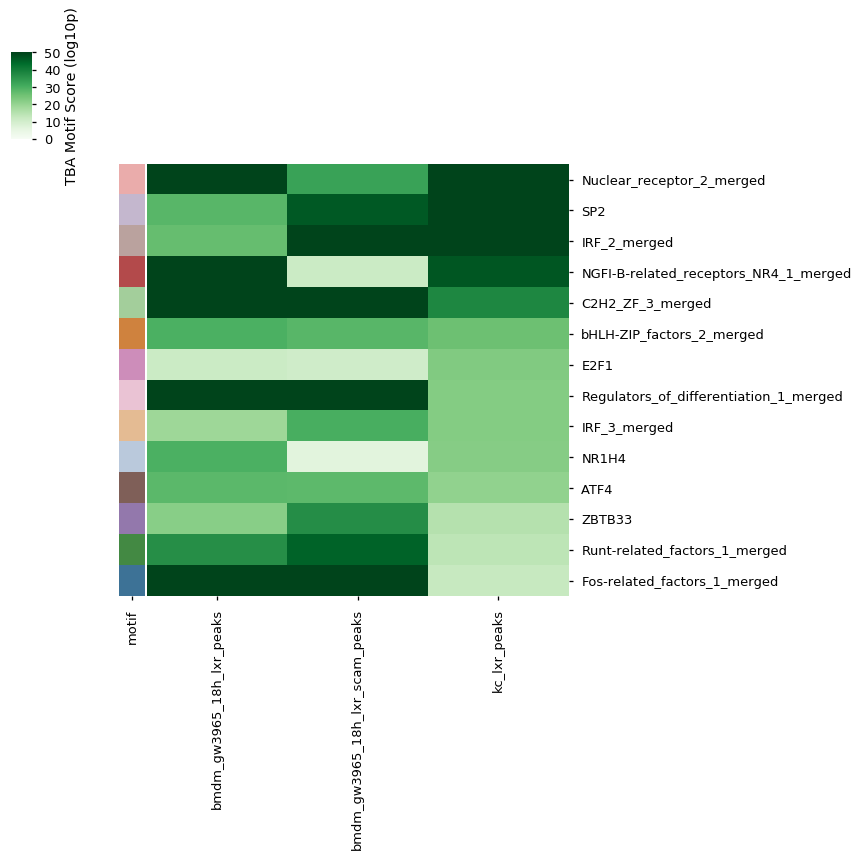

In [38]:
n_motifs = 10
motif_set = set()

# select top n motifs for each cell
for cell in filtered_frame.columns.values:
    motif_set.update(filtered_frame[cell].sort_values(ascending=False).index.values[:n_motifs])

# make dictionary of motif colors
motif_color = dict( zip(motif_set, sns.color_palette('tab20', n_colors=len(motif_set), desat=0.6).as_hex()) )
motif_color_series = pd.Series(motif_color, name='motif')

top_motif_frame = filtered_frame.loc[motif_set, :]
top_motif_frame.sort_values('kc_lxr_peaks', ascending=False, inplace=True)
# top_motif_frame['mean'] = top_motif_frame.mean(1)
# top_motif_frame.sort_values('mean', ascending=False, inplace=True)
# top_motif_frame.drop(columns='mean', inplace=True)
    
# create heatmap
hm = sns.clustermap(
    top_motif_frame.loc[:, :],
    vmin=0,
    vmax=50,
    cmap='Greens',
    cbar_kws={'label': 'TBA Motif Score (log10p)'},
    row_colors=motif_color_series,
    row_cluster=False,
    col_cluster=False)

plt.savefig('./figures/tba_lxr_top_differential_motifs_heatmap.pdf', bbox_inches='tight')

### Plot expression of genes within TF Set

get mean rpkm

In [27]:
# create avg rpkm matrix for filtering
rpkm_avg = pd.DataFrame([
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('BMDM').values].mean(1),
    rpkm_quant.loc[:, pd.Series(rpkm_quant.columns).str.contains('KupfferTim4Pos_RNA_Contro').values].mean(1)],
    index=['bmdm',
           'kc']).T

# change index to gene names
# rpkm_avg['gene'] = hg38_gene
# rpkm_avg = rpkm_avg.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes not expressed at rpkm > 4 in at least 1 sample
rpkm_avg_filt = rpkm_avg.loc[(rpkm_avg > 4).any(1), :]

In [28]:
all_tf = []
tf_color_set = []
tf_color_dict = {}
tf_set = []

rpkm_avg_filt_upper = rpkm_avg_filt
rpkm_avg_filt_upper.index = rpkm_avg_filt_upper.index.str.upper()

for motif, row in top_motif_frame.T.iteritems():
    try:
        tst = motif_meta.loc[motif, 'Gene']
        for tf in motif_meta.loc[motif, 'Gene'].split('|'):
            all_tf.append(tf.upper())
            try:
                # print(rpkm_filt.loc[tf, :])
                test = rpkm_avg_filt_upper.loc[tf.upper(), :]
                tf_set.append(tf.upper())
                tf_color_set.append( (tf.upper(), motif_color[motif]) )
                tf_color_dict[tf.upper()] = motif_color[motif]
            except KeyError:
                print(tf, 'not in rpkm_filt')
                pass
    except KeyError:
        print(motif, 'not in motif metadata')
        pass

Nuclear_receptor_2_merged not in motif metadata
NR4A2 not in rpkm_filt
PPARA not in rpkm_filt
NR1I2 not in rpkm_filt
NR1I3 not in rpkm_filt
ZNF76 not in rpkm_filt
ZNF143 not in rpkm_filt
ARNTL2 not in rpkm_filt
MLXIPL not in rpkm_filt
MEF2B not in rpkm_filt
IRF6 not in rpkm_filt
NR1H4 not in rpkm_filt
RUNX3 not in rpkm_filt
RUNX2 not in rpkm_filt
FOSL1 not in rpkm_filt
NFE2 not in rpkm_filt
FOSB not in rpkm_filt


In [29]:
print('Number of motifs:', filtered_frame.shape[0])
print('Number of TFs associated with motifs:', len(set(all_tf)))
print('Nubmer of TFs expressed above threshold:', len(tf_color_set))

Number of motifs: 78
Number of TFs associated with motifs: 49
Nubmer of TFs expressed above threshold: 34


## plot tf expression

plot as heatmap

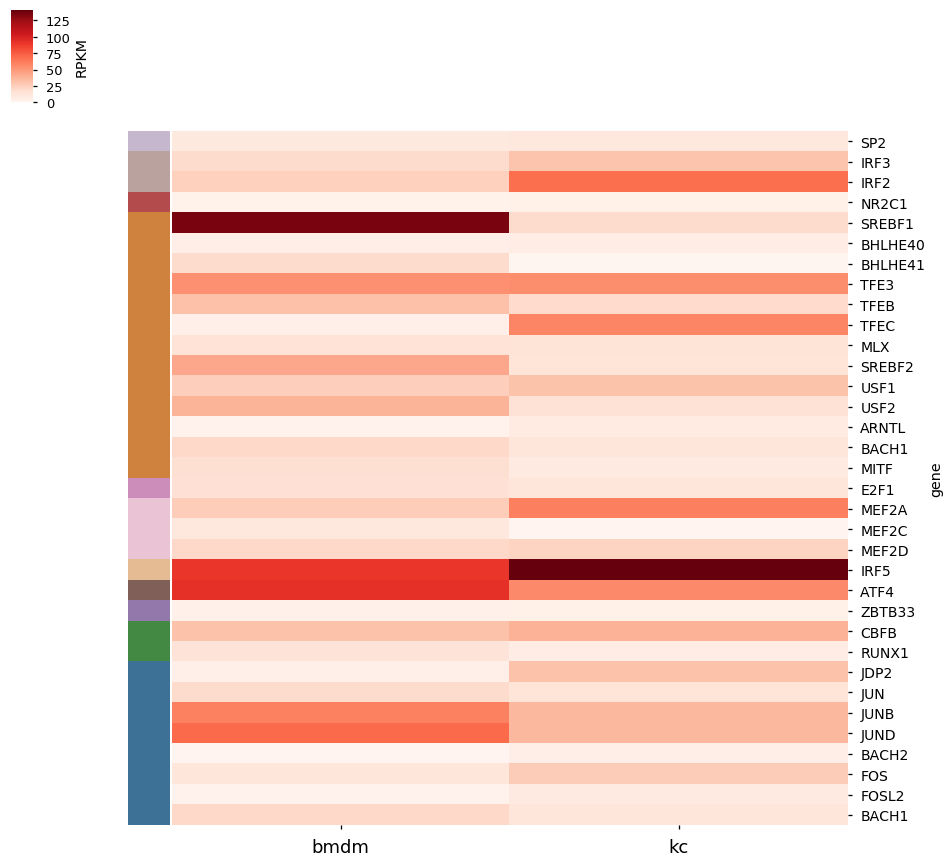

In [32]:
hm=sns.clustermap(rpkm_avg_filt.loc[tf_set, :],
            cmap='Reds',
            cbar_kws={'label': 'RPKM'},
            row_cluster=False,
            col_cluster=False,
            row_colors=[row[1] for row in tf_color_set],
            vmin=0,
            figsize=(15,15))

plt.setp(hm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=14);
plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0, fontsize=18);

plot as barplots

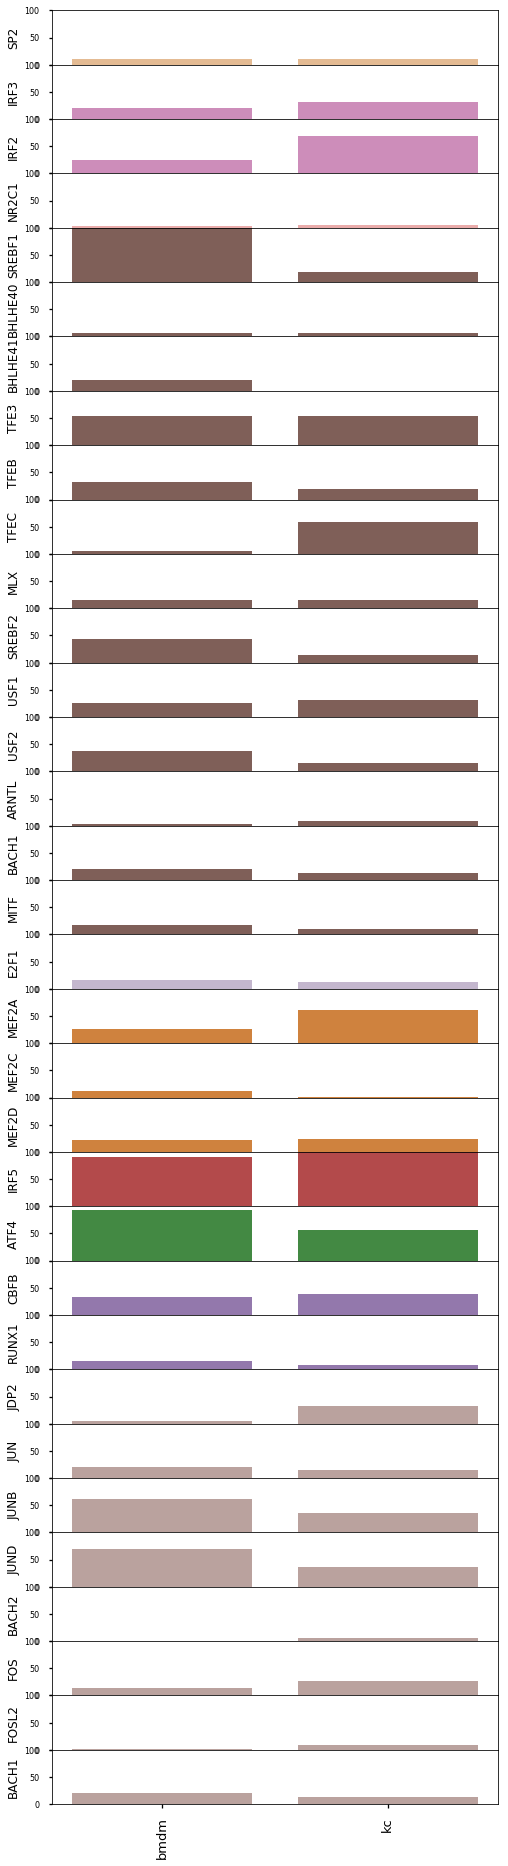

In [24]:
fig, axs = plt.subplots(len(tf_color_set), 1, sharex=True, figsize=(8, len(tf_color_set)))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
for gene, color in tf_color_set:
    ind = np.arange(len(rpkm_avg_filt.loc[gene, :]));
    axs[counter].bar(ind, rpkm_avg_filt.loc[gene, :], color=color);
    axs[counter].set_ylabel(gene, fontsize=12);
    axs[counter].set_ylim([0, 100])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_avg_filt.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8)
    counter +=1

* IRF2 has been shown to be involved in repressing the expression of caspase 1 in response to LPS injection. (Cuesta et al, 2007 & 2003, J. Imm)
* Tontonoz's group at UCLA found that IRF3 interacts with LXR at binding sites to repress activity (did studies at Abca1 locus)

### Repeat with repopulating monocyte data

In [25]:
# read in rpkm_timecourse
rpkm_timecourse = pd.read_csv('/home/h1bennet/kupffer_timecourse_tba/results/180830_atac/expression/rna_exp_rpkm.tsv', sep='\t')
rpkm_timecourse.set_index(rpkm_timecourse.columns.values[0], inplace=True)
rpkm_timecourse.index.rename('refseqID', inplace=True)
# set rpkm_timecourse index
mm10_gene = rpkm_timecourse['Annotation/Divergence'].str.split('|').str[0]

# clean up column names
# rename rpkm_timecourse columns
rpkm_timecourse = rpkm_timecourse.rename(columns=dict(zip(rpkm_timecourse.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm_timecourse.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
# change index to gene names
rpkm_timecourse['gene'] = mm10_gene.str.upper()
rpkm_timecourse = rpkm_timecourse.reset_index().set_index('gene').drop(labels='refseqID', axis=1)

# filter genes with length < 250 bp
rpkm_timecourse = rpkm_timecourse.loc[rpkm_timecourse.Length >= 250, :]
rpkm_timecourse = rpkm_timecourse.iloc[:, 7:]
rpkm_timecourse = rpkm_timecourse.iloc[:, [1,2,3,7,8,11,10,5,6,12,13]]

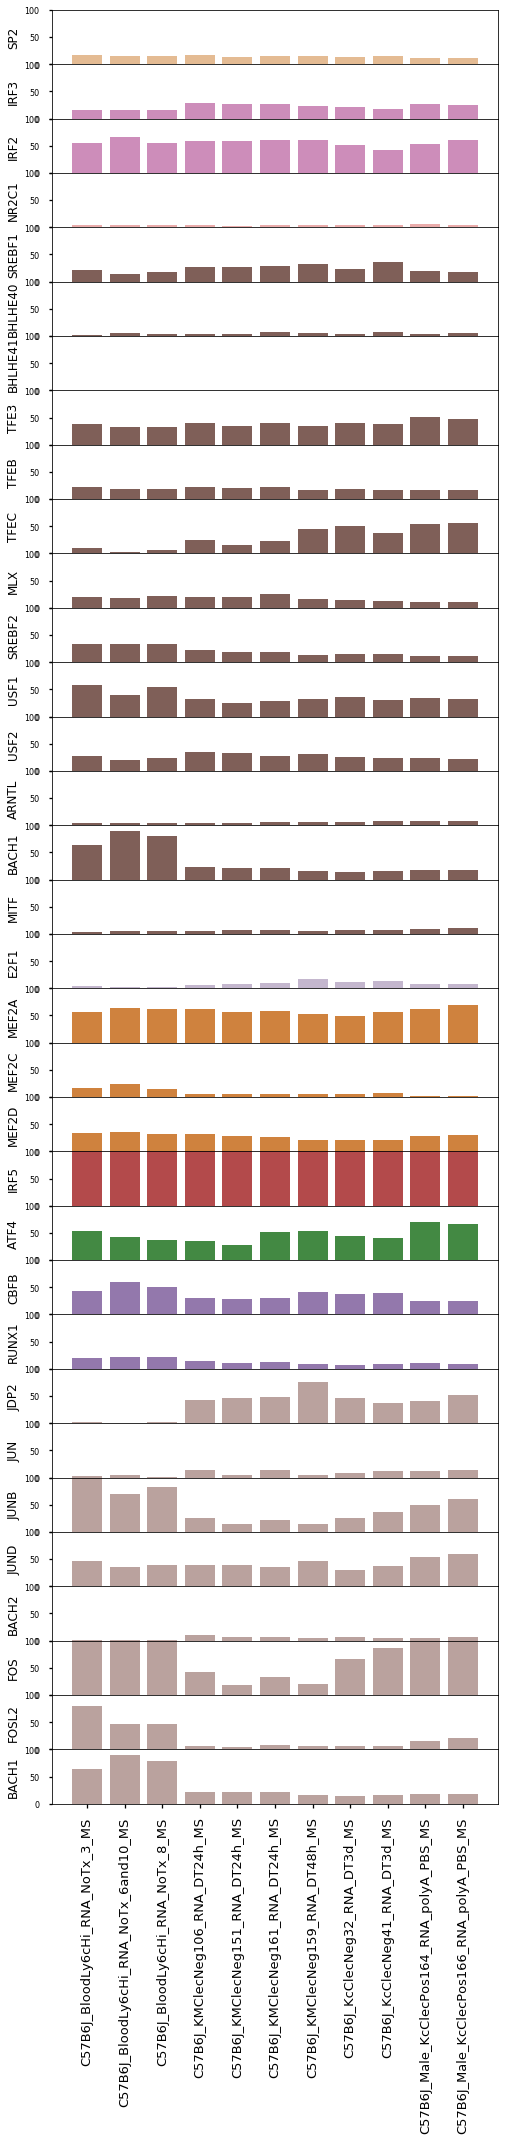

In [26]:
fig, axs = plt.subplots(len(tf_color_set), 1, sharex=True, figsize=(8, len(tf_color_set)))
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
# remove horizontal space between axis
fig.subplots_adjust(hspace=0)
# iterate through and plot
counter = 0
for gene, color in tf_color_set:
    ind = np.arange(len(rpkm_timecourse.loc[gene, :]));
    axs[counter].bar(ind, rpkm_timecourse.loc[gene, :], color=color);
    axs[counter].set_ylabel(gene, fontsize=12);
    axs[counter].set_ylim([0, 100])
    axs[counter].set_xticks(ind);
    axs[counter].set_xticklabels(rpkm_timecourse.loc[gene, :].index.values, rotation=90)
    axs[counter].tick_params(axis='y', which='major', labelsize=8)
    counter +=1

make individual tf family plots

In [27]:
rpkm_avg_filt.columns.values

array(['bmdm', 'kc'], dtype=object)

### MA Style Plot

In [28]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = tf_mean_pval_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = tf_mean_pval_frame[treatment]
    weights = tf_mean_weight_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
tf_frame = pd.DataFrame(treatment_orientedPvals_dict, index = tf_mean_pval_frame.index.values)

# OPTION: exclude negatively correlated motivs
tf_frame = tf_frame[tf_frame.max(axis=1) > 2]


In [29]:
tf_frame.columns.values

array(['bmdm', 'kc'], dtype=object)

Can also use the homer based frame

In [30]:
homer_mean_pval_frame = pd.read_csv('./tf_mean_pval_homer.tsv', sep='\t', index_col=0)
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = homer_mean_pval_frame.columns
treatment_orientedPvals_dict = {}
# create treatement oriented p val frame
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = homer_mean_pval_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [-np.log10(x +pseudocount) for x in pvals]
    # store in dict
    treatment_orientedPvals_dict[treatment] = oriented_pvals

# create data frame
tf_frame_homer = pd.DataFrame(treatment_orientedPvals_dict, index = homer_mean_pval_frame.index.values)

# OPTION: exclude negatively correlated motivs
tf_frame_homer = tf_frame_homer[tf_frame_homer.max(axis=1) > 2]

tf_frame_homer.index = tf_frame_homer.index.to_series().str.split('(').str[0].str.upper()

In [31]:
# select samples
samp1='ncorwt_kupffertim4pos_nashdiet_21wk'
samp2='ncorwt_kupffer_controldiet_0wk'

# get average expression and difference in ABTBA p val
avg_exp = (rpkm_avg_filt[samp1] + rpkm_avg_filt[samp2])/2
sig_delta = tf_frame[samp1] - tf_frame[samp2]

# find TFs in both data sets
shared_tfs = set(avg_exp.index).intersection(sig_delta.index)

# make plot
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(
    x=avg_exp[shared_tfs],
    y=sig_delta[shared_tfs],
    s=20)
ax.set_xlabel('avg rpkm')
ax.set_ylabel('TBA Score Diff')
ax.set_title('%s vs. %s' % (samp1, samp2))

# label top genes
for tf in shared_tfs:
    if (np.abs(sig_delta[tf]) >= 4 and avg_exp[tf] >= 20):
        # print(i, point)
        ax.text(avg_exp[tf]+0.2,
                sig_delta[tf]+0.2,
                str(tf),
                fontsize=14)

plt.scatter(
    x=avg_exp['EGR2'],
    y=sig_delta['EGR2'],
    s=15,
    c='r')

KeyError: 'ncorwt_kupffertim4pos_nashdiet_21wk'

### Compare to HOMER

In [ ]:
# select samples
samp1='ncorwt_kupffertim4pos_nashdiet_21wk'
samp2='ncorwt_kupffer_controldiet_0wk'

# get average expression and difference in ABTBA p val
avg_exp = (rpkm_avg_filt[samp1] + rpkm_avg_filt[samp2])/2
sig_delta = tf_frame[samp1] - tf_frame[samp2]
sig_delta_homer = tf_frame_homer['_'.join(samp1.split('_')[:-1])]\
        - tf_frame_homer['_'.join(samp2.split('_')[:-1])]

# find TFs in both data sets
shared_tfs = set(avg_exp.index).intersection(sig_delta.index)
shared_tfs_homer = set(avg_exp.index).intersection(sig_delta_homer.index)

# make plot
fig, axs = plt.subplots(1, 2, figsize=(24,12))
axs[0].scatter(
    x=avg_exp[shared_tfs],
    y=sig_delta[shared_tfs],
    s=20)
axs[0].set_xlabel('avg rpkm')
axs[0].set_ylabel('TBA Score Diff')
axs[0].set_title('%s vs. %s' % (samp1, samp2))

# label top genes
for tf in shared_tfs:
    if (np.abs(sig_delta[tf]) >= 5 and avg_exp[tf] >= 20):
        # print(i, point)
        axs[0].text(avg_exp[tf]+0.2,
                sig_delta[tf]+0.2,
                str(tf),
                fontsize=14)
        
# make plot
axs[1].scatter(
    x=avg_exp[shared_tfs_homer],
    y=sig_delta_homer.loc[shared_tfs_homer],
    s=20,
    c='red')
axs[1].set_xlabel('avg rpkm')
axs[1].set_ylabel('TBA Score Diff')
axs[1].set_title('%s vs. %s' % (samp1, samp2))

# label top genes
for tf in shared_tfs_homer:
    #if (np.abs(sig_delta_homer[tf]) >= 5 and avg_exp[tf] >= 20):
        # print(i, point)
    axs[1].text(avg_exp[tf]+0.2,
            sig_delta_homer[tf]+0.2,
            str(tf),
            fontsize=14)
        
# plt.scatter(
#     x=avg_exp['RELA'],
#     y=sig_delta['RELA'],
#     s=15,
#     c='r')